# Forest Cover Prediction

- **Class Section: 2019 Summer - Monday 6:30 PM**

- **Project Team: Adam Sohn, Curtis Lin, Erik Hou, Youzhi (Chloe) Wu**


=====================================================================================================================

## 1. Problem Description & Objectives

The objective of this project is to use a machine learning algorithm to predict the forest canopy cover type by using cartographic variables only. The seed information for this project is a dataset provided by the US Forest Service (USFS) Region 2 Resource Information System. 

=====================================================================================================================

## 2. Dataset Description

The seed information for this project is a dataset provided by the US Forest Service (USFS) Region 2 Resource Information System. The dataset describes 30x30 meter cells in four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

The dataset contains binary columns of data for qualitative independent variables such as wilderness areas and soil type.
The dataset also contains continuous, unscaled, quantitative data to describe independant variables such as elevation and distance from roads.

Dataset: https://www.kaggle.com/c/forest-cover-type-prediction

=====================================================================================================================

## 3. Project Plan

1. Perform EDA to explore data, noting irregularities and relationships between variables.
2. Pilot study several applicable classification algorithms to hone in on most promising algorithm(s).
3. Apply feature engineering to improve classifier performance: potential algorithms for feature engineering may include
    - Decision tree
    - Random forest regressor
    - Use domain knowledge to featurize soil types
    - PCA to reduce soil types
4. Optimize promising algorithm(s) with bagging, ensemble and cross validations
5. Summarize findings.

=====================================================================================================================

## 4. Package Loading

In [0]:
%matplotlib inline

# General libraries
import csv
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from collections import defaultdict
from numpy import genfromtxt

# SK-learn libraries for learning.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# SK-learn model packages 
from sklearn import svm
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier 

# SK-learn libraries for evaluation.
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.model_selection import ShuffleSplit

import pandas as pd
pd.set_option('display.max_columns', None)

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

## 5. Data Loading


Below are 3 different data loaders to compliment different coding methodologies. Methodologies will be condensed to a single loader in future revision.

In [2]:
### Pandas dataframe for EDA, feature engineering

train_raw_df = pd.read_csv("./forest-cover-type-prediction/train.csv")
train_df = train_raw_df.loc[:,"Elevation":] #remove ID column from df
test_df_no_label = pd.read_csv('./forest-cover-type-prediction/test.csv') # this dataframe is for final prediction


### Call this function after feature engineering on pandas dataframe to generate numpy array
def data_to_np(my_data=train_raw_df.values):
    '''Takes numpy array as argument in order to return train/dev/test datasets 
    according to desired feature engineering. Default is no feature engineering.'''
#     my_data = my_data.values
    np.random.seed(0)
    data = my_data[1:, 1:my_data.shape[1]-1]  # avoid getting headers and ID column
    labels = my_data[1:,-1]
    
    shuffle = np.random.permutation(np.arange(data.shape[0]))

    shuffled_data = data[shuffle]
    shuffled_labels = labels[shuffle]
    shuffled_labels = shuffled_labels - 1

    # split the data to 60% train, 20% dev and 20% test
    num_train = int(shuffled_data.shape[0]*0.6)
    num_dev = int(shuffled_data.shape[0]*0.8)

    train_data, train_labels = shuffled_data[:num_train], shuffled_labels[:num_train]
    dev_data, dev_labels = shuffled_data[num_train:num_dev], shuffled_labels[num_train:num_dev]
    test_data, test_labels = shuffled_data[num_dev:], shuffled_labels[num_dev:]

    return train_data, dev_data, test_data, train_labels, dev_labels, test_labels

FileNotFoundError: ignored

=====================================================================================================================

## 6. EDA

### <font color=blue> 1. Basic information and descriptive statistics</font>

In [0]:
print("Test data shape:",test_df_no_label.shape)
print(test_df_no_label.columns)

Test data shape: (565892, 55)
Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_

> Test_df from test.csv does not have cover_type column. It is intended for prediction only. As such, we will need to subset train_df to train and dev datasets for our modeling process. 

In [0]:
# Count the number of instances of each class
print(train_df.groupby('Cover_Type').size())

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64


> The cover types are equally divided into 7 categories in our training csv. So there is no skewness in our dataset. 

### Geographic information ### 

          Elevation        Aspect         Slope
count  15120.000000  15120.000000  15120.000000
mean    2749.322553    156.676653     16.501587
std      417.678187    110.085801      8.453927
min     1863.000000      0.000000      0.000000
25%     2376.000000     65.000000     10.000000
50%     2752.000000    126.000000     15.000000
75%     3104.000000    261.000000     22.000000
max     3849.000000    360.000000     52.000000


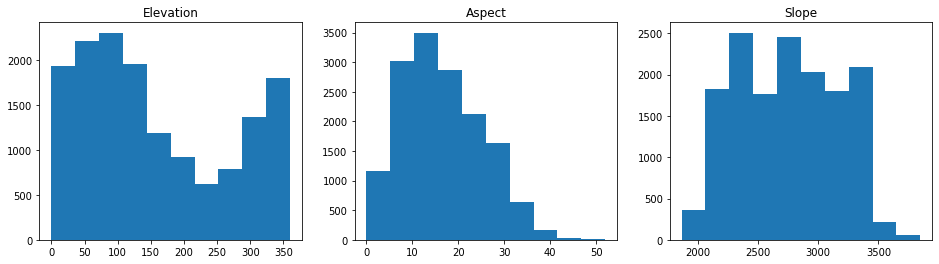

In [0]:
# Geographic information

print("### Geographic information ### \n")
print(train_df.iloc[:,0:3].describe())

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
geograpy = ['Elevation', 'Aspect', 'Slope']

for i in range(0, 3):
    ax[i-1].hist(train_df.loc[:,geograpy[i]])
    ax[i-1].set_title(geograpy[i-1])   

### Hydrological information ### 

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology
count                      15120.000000                    15120.000000
mean                         227.195701                       51.076521
std                          210.075296                       61.239406
min                            0.000000                     -146.000000
25%                           67.000000                        5.000000
50%                          180.000000                       32.000000
75%                          330.000000                       79.000000
max                         1343.000000                      554.000000


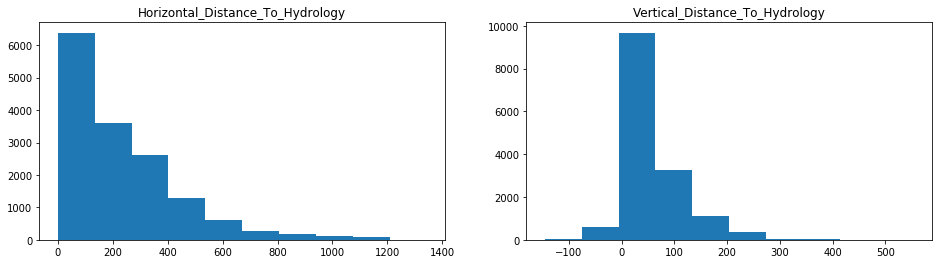

In [0]:
# Hydrological information

print("### Hydrological information ### \n")
print(train_df.iloc[:,3:5].describe())

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
hydrology = ['Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']

for i in range(2):
    ax[i].hist(train_df.loc[:,hydrology[i]])
    ax[i].set_title(hydrology[i])

### Distance to roadways and fire points ### 

       Horizontal_Distance_To_Roadways  Horizontal_Distance_To_Fire_Points
count                     15120.000000                        15120.000000
mean                       1714.023214                         1511.147288
std                        1325.066358                         1099.936493
min                           0.000000                            0.000000
25%                         764.000000                          730.000000
50%                        1316.000000                         1256.000000
75%                        2270.000000                         1988.250000
max                        6890.000000                         6993.000000


Text(0.5, 1.0, 'Horizontal_Distance_To_Fire_Points')

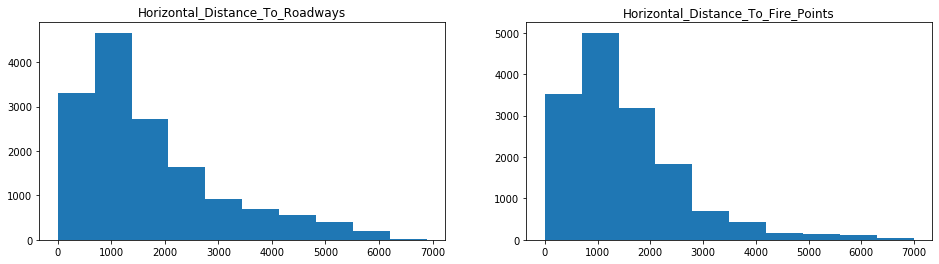

In [0]:
# Distance to roadways and fire points

print("### Distance to roadways and fire points ### \n")
print(train_df.loc[:,['Horizontal_Distance_To_Roadways','Horizontal_Distance_To_Fire_Points']].describe())

fig, ax = plt.subplots(1, 2, figsize=(16, 4))


ax[0].hist(train_df.loc[:,'Horizontal_Distance_To_Roadways'])
ax[0].set_title('Horizontal_Distance_To_Roadways')
ax[1].hist(train_df.loc[:,'Horizontal_Distance_To_Fire_Points'])
ax[1].set_title('Horizontal_Distance_To_Fire_Points')

### Hillshade information (0 to 255 index) ### 

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm
count   15120.000000    15120.000000   15120.000000
mean      212.704299      218.965608     135.091997
std        30.561287       22.801966      45.895189
min         0.000000       99.000000       0.000000
25%       196.000000      207.000000     106.000000
50%       220.000000      223.000000     138.000000
75%       235.000000      235.000000     167.000000
max       254.000000      254.000000     248.000000


Text(0.5, 1.0, 'Noon vs 3pm')

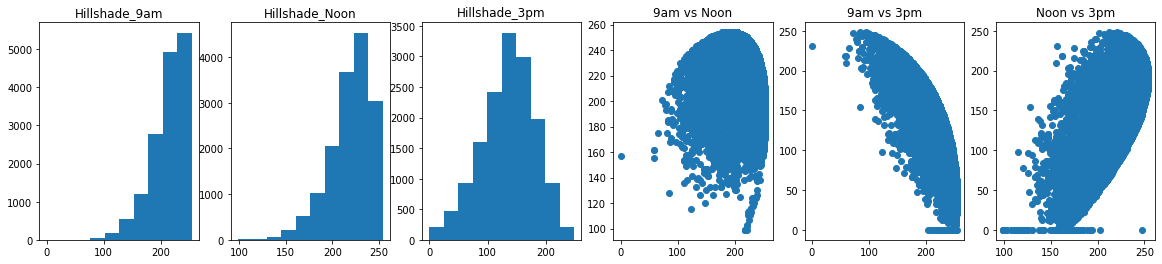

In [0]:
# Hillshade information (0 to 255 index) 

print("### Hillshade information (0 to 255 index) ### \n")
print(train_df.iloc[:,6:9].describe())

fig, ax = plt.subplots(1, 6, figsize=(20, 4))
hillshade = ['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

for i in range(3):
    ax[i].hist(train_df.loc[:,hillshade[i]])
    ax[i].set_title(hillshade[i])
    
ax[3].scatter(train_df.loc[:,'Hillshade_9am'], train_df.loc[:,'Hillshade_Noon'])
ax[3].set_title("9am vs Noon")
ax[4].scatter(train_df.loc[:,'Hillshade_9am'], train_df.loc[:,'Hillshade_3pm'])
ax[4].set_title("9am vs 3pm")
ax[5].scatter(train_df.loc[:,'Hillshade_Noon'], train_df.loc[:,'Hillshade_3pm'])
ax[5].set_title("Noon vs 3pm")

### Wilderness area information ### 

       Wilderness_Area1  Wilderness_Area2  Wilderness_Area3  Wilderness_Area4
count      15120.000000      15120.000000      15120.000000      15120.000000
mean           0.237897          0.033003          0.419907          0.309193
std            0.425810          0.178649          0.493560          0.462176
min            0.000000          0.000000          0.000000          0.000000
25%            0.000000          0.000000          0.000000          0.000000
50%            0.000000          0.000000          0.000000          0.000000
75%            0.000000          0.000000          1.000000          1.000000
max            1.000000          1.000000          1.000000          1.000000


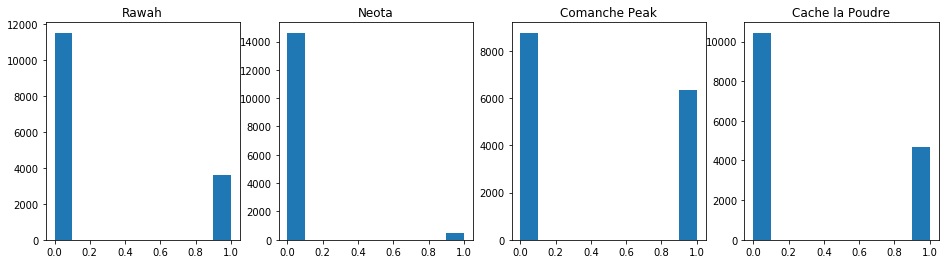

In [0]:
# Wilderness area information

print("### Wilderness area information ### \n")
print(train_df.iloc[:,10:14].describe())

fig, ax = plt.subplots(1, 4, figsize=(16, 4))
wilderness = ['Rawah', 'Neota', 'Comanche Peak', 'Cache la Poudre']

for i in range(4):
    ax[i].hist(train_df.iloc[:,i+10])
    ax[i].set_title(wilderness[i])

In [0]:
# Soil information (binary data)

train_df.iloc[:,14:54].describe()

,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357
std,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


1 Cathedral family - Rock outcrop complex, extremely stony.

2 Vanet - Ratake families complex, very stony.

3 Haploborolis - Rock outcrop complex, rubbly.

4 Ratake family - Rock outcrop complex, rubbly.

5 Vanet family - Rock outcrop complex complex, rubbly.

6 Vanet - Wetmore families - Rock outcrop complex, stony.

7 Gothic family.

8 Supervisor - Limber families complex.

9 Troutville family, very stony.

10 Bullwark - Catamount families - Rock outcrop complex, rubbly.

11 Bullwark - Catamount families - Rock land complex, rubbly.

12 Legault family - Rock land complex, stony.

13 Catamount family - Rock land - Bullwark family complex, rubbly.

14 Pachic Argiborolis - Aquolis complex.

15 unspecified in the USFS Soil and ELU Survey.

16 Cryaquolis - Cryoborolis complex.

17 Gateview family - Cryaquolis complex.

18 Rogert family, very stony.

19 Typic Cryaquolis - Borohemists complex.

20 Typic Cryaquepts - Typic Cryaquolls complex.

21 Typic Cryaquolls - Leighcan family, till substratum complex.

22 Leighcan family, till substratum, extremely bouldery.

23 Leighcan family, till substratum - Typic Cryaquolls complex.
24 Leighcan family, extremely stony.

25 Leighcan family, warm, extremely stony.

26 Granile - Catamount families complex, very stony.

27 Leighcan family, warm - Rock outcrop complex, extremely stony.

28 Leighcan family - Rock outcrop complex, extremely stony.

29 Como - Legault families complex, extremely stony.

30 Como family - Rock land - Legault family complex, extremely stony.

31 Leighcan - Catamount families complex, extremely stony.

32 Catamount family - Rock outcrop - Leighcan family complex, extremely stony.

33 Leighcan - Catamount families - Rock outcrop complex, extremely stony.

34 Cryorthents - Rock land complex, extremely stony.

35 Cryumbrepts - Rock outcrop - Cryaquepts complex.

36 Bross family - Rock land - Cryumbrepts complex, extremely stony.

37 Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.

38 Leighcan - Moran families - Cryaquolls complex, extremely stony.

39 Moran family - Cryorthents - Leighcan family complex, extremely stony.

40 Moran family - Cryorthents - Rock land complex, extremely stony.

### <font color=blue> 2. Correlation checking among variables</font>

In [0]:
# create the function to plot correlation heatmap

def generate_cor_graph(data, size=(15,15), title = None):
    
    corr = data.corr()
    fig = plt.figure(figsize = size)
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(data.columns),1)
    ax.set_xticks(ticks)
    plt.xticks(rotation=90)
    ax.set_yticks(ticks)
    ax.set_xticklabels(data.columns)
    ax.set_yticklabels(data.columns)
    plt.tight_layout()
    plt.title(title, y=1.2)
    plt.show()

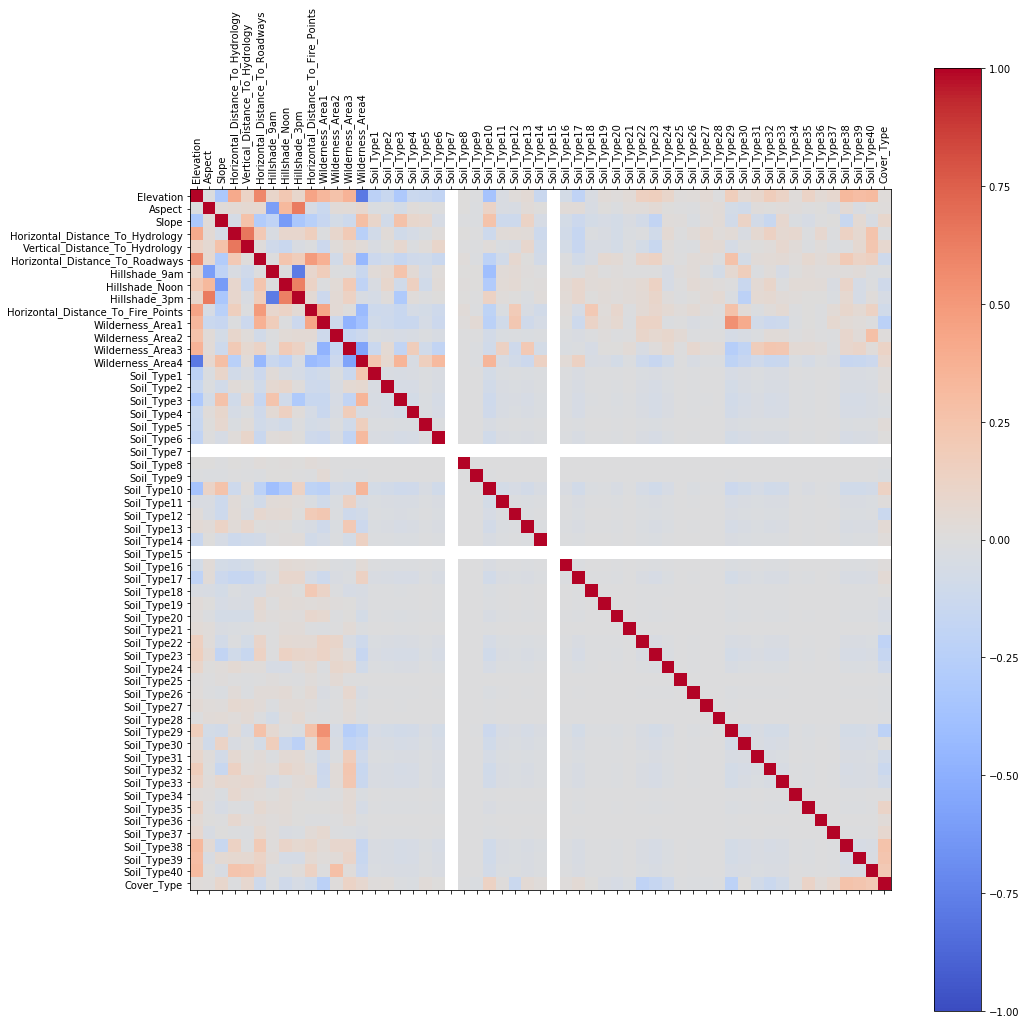

In [0]:
# Plot correlation heatmap to find highly correlated variables /features

generate_cor_graph(train_df)

> From above heat map, the following variables are considered relatively high correlated with cover type:
- Horizontal_Distance_To_Roadways
- Horizontal_Distance_To_Fire_Points
- Hillshade_Noon
- Wilderness_Area1
- Soil_Type12, Soil_Type22, Soil_Type23, Soil_Type29, Soil_Type32, Soil_Type38, Soil_Type39, Soil_Type40

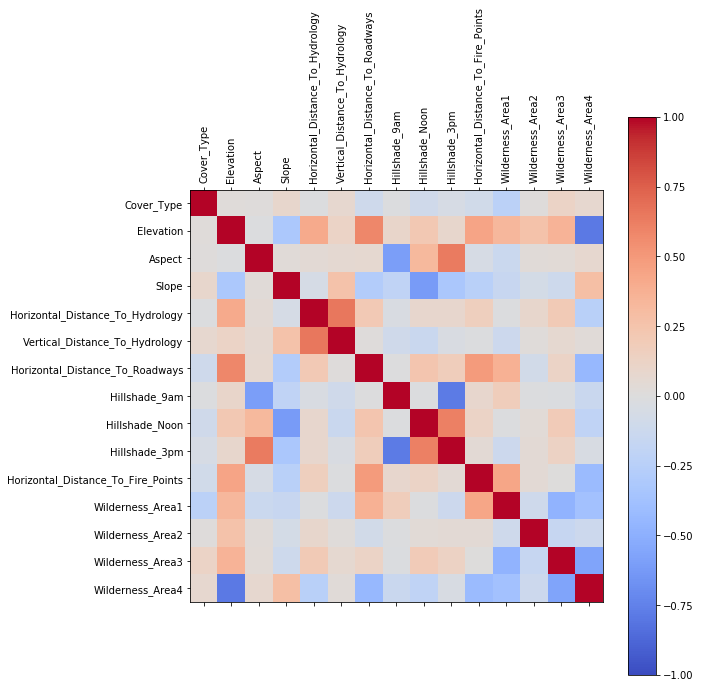

In [0]:
cols = [i for i in range(0,14)]
cols = [-1] + cols
data_soil_id_exclu = train_df.iloc[:,cols]
generate_cor_graph(data_soil_id_exclu, (10,10))

/Users/curtislin/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/curtislin/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


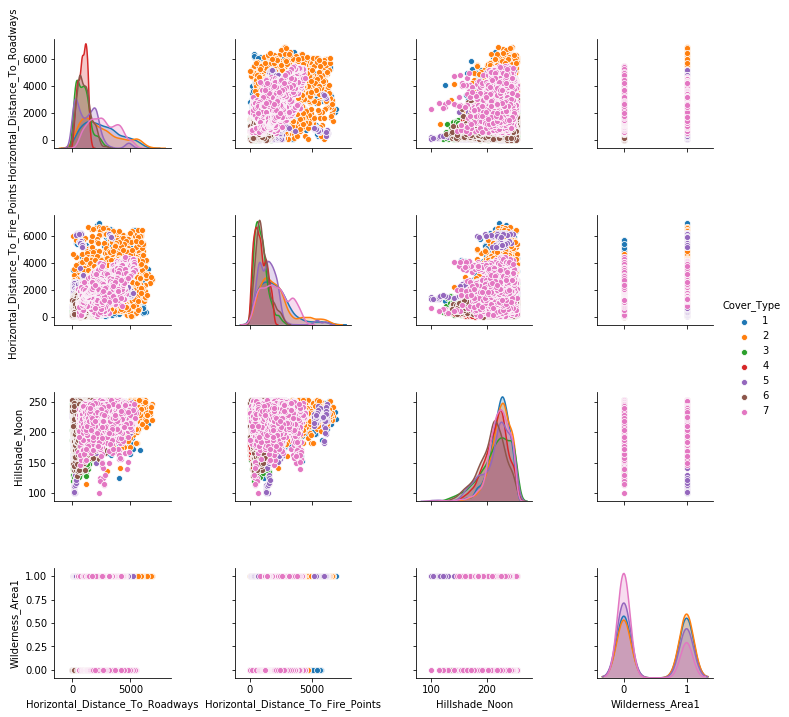

In [0]:
# Variables that are relatively high correlated with cover type are selected here
sns.pairplot(train_df, hue='Cover_Type', vars=["Horizontal_Distance_To_Roadways",
                                               "Horizontal_Distance_To_Fire_Points", 
                                               "Hillshade_Noon","Wilderness_Area1"])

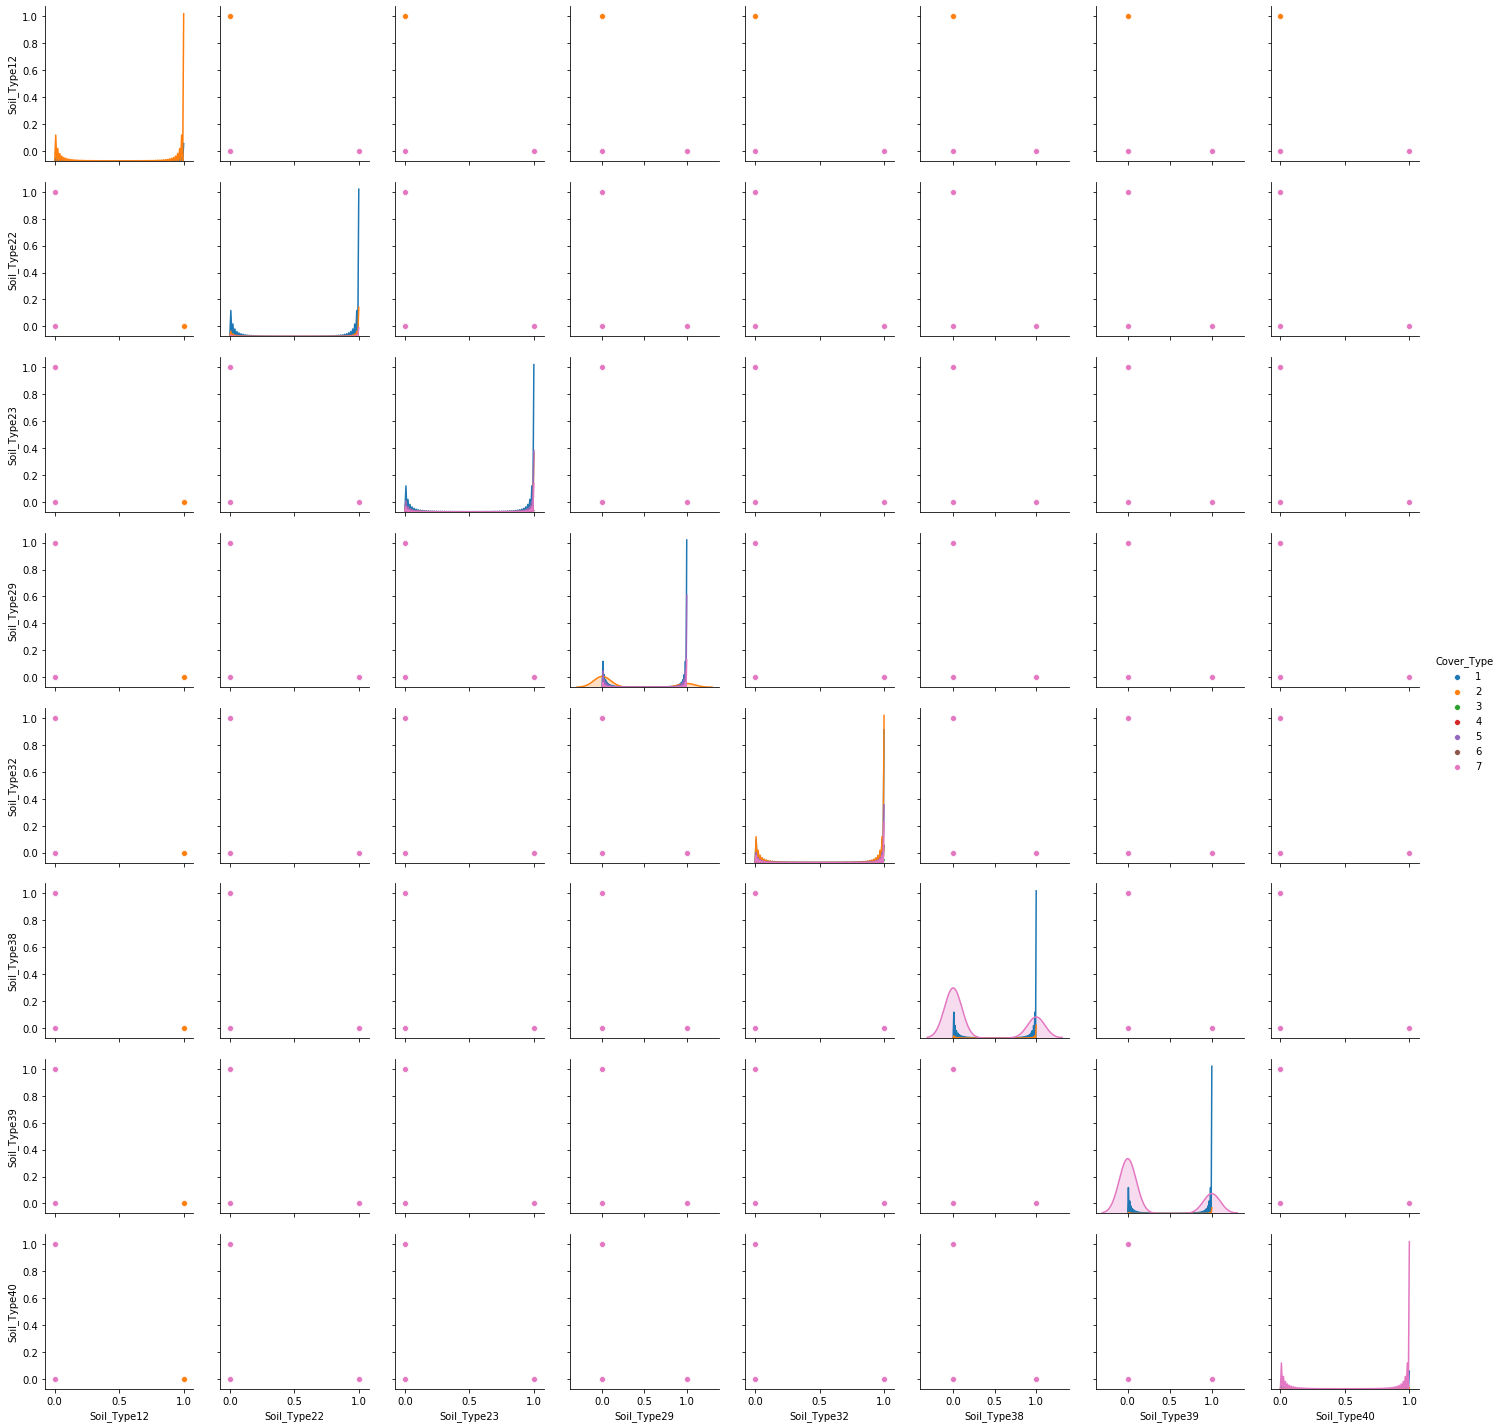

In [0]:
# Variables that are relatively high correlated with cover type are selected here
sns.pairplot(train_df, hue='Cover_Type', vars=["Soil_Type12","Soil_Type22",
                                               "Soil_Type23","Soil_Type29",
                                               "Soil_Type32","Soil_Type38",
                                               "Soil_Type39","Soil_Type40"])

In [0]:
# cover_types = np.sort(train_df.iloc[:, -1].unique())
# df_dict = {}

# for cover_type in cover_types:
#     df_dict[cover_type] = train_df.loc[train_df['Cover_Type'] == cover_type]

# for cover_type in cover_types:
#     generate_cor_graph(data = df_dict[cover_type], title = 'Cover Type' + str(cover_type))

=====================================================================================================================

## 7. Feature Engineering

### <font color=blue> 1. Feature information</font>

Elevation - Elevation in meters

Aspect - Aspect in degrees azimuth

Slope - Slope in degrees

Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features

Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features

Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway

Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice

Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice

Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice

Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points

Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation

Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

### <font color=blue> 2. Perform feature engineering on soil types</font>

In [0]:
soil_feature = pd.read_csv("./forest-cover-type-prediction/soil_feature.csv")
print(soil_feature.head())

    Soil_Type  Rock outcrop  Rock Land  Complex  Stony  Rubbly  Cyraquolls  \
0  Soil_Type1             1          0        1      1       0           0   
1  Soil_Type2             0          0        1      1       0           0   
2  Soil_Type3             1          0        1      0       1           0   
3  Soil_Type4             1          0        1      0       1           0   
4  Soil_Type5             1          0        1      0       1           0   

   Cryumbrepts  Cryorthents  Leighcan  Till substratum  Catmount  Legault  \
0            0            0         0                0         0        0   
1            0            0         0                0         0        0   
2            0            0         0                0         0        0   
3            0            0         0                0         0        0   
4            0            0         0                0         0        0   

   Moran  Bullwark  Crayaquepts  Vanet  Como  
0      0         0   

#### Feature Engineering Round 1 (Soil_Type15 , Id)
'Soil_Type15' is 'unspecified in the USFS Soil and ELU Survey.' This is not a distinct category and therefore does not aid classification. <br>
'Id' is not a feature, but rather acts to remove randomization, which is undesired.<br>

* Eliminate any row containing 'Soil_Type15'. Eliminate column for 'Soil_Type15'.
* Eliminate column for 'Id' by data_to_np() function

In [0]:
train_df1 = train_raw_df.drop(columns = ['Soil_Type15'])

#### Feature Engineering Round 2 (Soil_Type to features, keep Soil_Type)
Description of Soil Types yields commonalities which expands a sample's feature set.

* Create single column in train_df & test_df for 'Soil_Type' to match soil_feature featurizer table.
* Merge train_df and test_df on soil_feature featurizer table 'Soil_Type' column
* Eliminate Soil_Type columns. 
* Inclusive of Round1

In [0]:
#Import data of featurizer table
soil_feature = pd.read_csv('./forest-cover-type-prediction/soil_feature.csv')

#Establish dataframes as deep copies
train_df2 = train_df1.copy(deep= True)
# test_df2 = test_df1.copy(deep= True)

#Aggregating soil types in train_df2 and test_df2 for use as merge index
soil_cols = ['Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19',
       'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23',
       'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
       'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31',
       'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35',
       'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39',
       'Soil_Type40']
train_df2['Soil_Type'] = train_df2[soil_cols].idxmax(axis=1)
# test_df2['Soil_Type'] = test_df2[soil_cols].idxmax(axis=1)

#Merging train_df2 and test_df2 with soil_feature
train_df2 = train_df2.merge(soil_feature, how = 'left', on = 'Soil_Type')
# test_df2 = test_df2.merge(soil_feature, how = 'left', on = 'Soil_Type')

#Manually reordering columns on train_df2 to make 'Cover_Type' at the end of the list.  
#Note this is not necessary for test2_df due to absence of 'Cover_Type' column. 
#Also eliminating 'Soil_Type' columns.
reordered_cols = ['Id', 'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Rock outcrop', 'Rock Land',
#        'Complex',
        'Stony', 'Rubbly', 'Cyraquolls', 'Cryumbrepts',
       'Cryorthents', 'Leighcan', 'Till substratum', 'Catmount', 'Legault',
       'Moran', 'Bullwark', 'Crayaquepts', 'Vanet', 'Como', 'Cover_Type']
train_df2 = train_df2[reordered_cols]

#### Feature Engineering Round 3 (Feature Reduction)
Reducing features to only those w/ random forest scoring > 0.1
* Inclusive of Round2

In [0]:
#Establish dataframes as deep copies
train_df3 = train_df2.copy(deep= True)
# test_df3 = test_df2.copy(deep= True)

train_df3 = train_df3.reset_index(drop=True)

print(train_df3.columns)
print(train_df3['Cover_Type'].head(9))

train_keys = ['Elevation', 'Moran', 'Horizontal_Distance_To_Roadways', 'Cover_Type']
test_keys = ['Elevation', 'Moran', 'Horizontal_Distance_To_Roadways']

train_df3 = train_df3[train_keys]
# test_df3 = test_df3[test_keys]

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Rock outcrop', 'Rock Land', 'Stony', 'Rubbly',
       'Cyraquolls', 'Cryumbrepts', 'Cryorthents', 'Leighcan',
       'Till substratum', 'Catmount', 'Legault', 'Moran', 'Bullwark',
       'Crayaquepts', 'Vanet', 'Como', 'Cover_Type'],
      dtype='object')
0    5
1    5
2    2
3    2
4    5
5    2
6    5
7    5
8    5
Name: Cover_Type, dtype: int64


### <font color=blue> 3. Perform feature engineering with standard normalization</font>

In [0]:
# seperate continuous and discrete variables 

train_raw_df_ID = train_raw_df.iloc[:,0]
train_raw_df_cont = train_raw_df.iloc[:,1:11]
train_raw_df_disc = train_raw_df.iloc[:,11:55]
train_raw_df_cover = train_raw_df.iloc[:,55]

In [0]:
# normalize continuous variables of training data 
train_raw_df_cont_norm = preprocessing.normalize(train_raw_df_cont)
train_raw_df_cont_norm = pd.DataFrame(train_raw_df_cont_norm)
train_raw_df_cont_norm.columns = train_raw_df_cont.columns.values
train_raw_df_cont_norm.index = train_raw_df_cont.index.values
# train_raw_df_cont_norm.head()

In [0]:
# combine normalized continuous variable and binary variable of training data 
train_raw_df_norm = pd.concat([train_raw_df_ID, train_raw_df_cont_norm, train_raw_df_disc, train_raw_df_cover], 
                              axis = 1)
train_raw_df_norm.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,0.380210,0.007469,0.000439,0.037787,0.000000,0.074695,0.032368,0.033979,0.021676,0.919622,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,0.382769,0.008276,0.000296,0.031331,-0.000887,0.057637,0.032513,0.034730,0.022316,0.919975,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,0.375821,0.018630,0.001206,0.035920,0.008712,0.426216,0.031363,0.031899,0.018094,0.820399,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,0.371810,0.020693,0.002403,0.032308,0.015754,0.412529,0.031774,0.031774,0.016288,0.829196,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,0.386275,0.006698,0.000298,0.022775,-0.000149,0.058202,0.032748,0.034832,0.022328,0.918725,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


> using PCA to reduce soil features

### <font color=blue> 4. Perform feature enginnering with Random Forest Regressor</font>

In [0]:
train_data, dev_data, test_data, train_labels, dev_labels, test_labels = data_to_np()

In [0]:
# Rank feature importance based off Random Forest Regressor results
names = train_df.columns.values
rf = RandomForestRegressor()
rf.fit(train_data, train_labels)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

/Users/curtislin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.4089, 'Elevation'), (0.0858, 'Horizontal_Distance_To_Fire_Points'), (0.0783, 'Horizontal_Distance_To_Roadways'), (0.0421, 'Horizontal_Distance_To_Hydrology'), (0.0368, 'Hillshade_3pm'), (0.0362, 'Soil_Type39'), (0.0361, 'Aspect'), (0.0356, 'Vertical_Distance_To_Hydrology'), (0.0316, 'Hillshade_9am'), (0.0302, 'Slope'), (0.0297, 'Hillshade_Noon'), (0.0247, 'Soil_Type38'), (0.0164, 'Soil_Type12'), (0.0141, 'Soil_Type32'), (0.0096, 'Wilderness_Area3'), (0.0096, 'Soil_Type35'), (0.009, 'Soil_Type29'), (0.0089, 'Soil_Type10'), (0.008, 'Wilderness_Area1'), (0.0068, 'Soil_Type22'), (0.0043, 'Soil_Type30'), (0.0037, 'Soil_Type4'), (0.0036, 'Soil_Type13'), (0.0034, 'Soil_Type40'), (0.003, 'Soil_Type33'), (0.003, 'Soil_Type24'), (0.0029, 'Soil_Type23'), (0.0026, 'Soil_Type31'), (0.0024, 'Soil_Type20'), (0.0021, 'Soil_Type17'), (0.0018, 'Soil_Type2'), (0.0015, 'Soil_Type3'), (0.0014, 'Wilderness_Area4'), (0.0012, 'Wilderness_Area2'), (0.001, 'Soil_Type11'), (0.

=====================================================================================================================

## 8. Sensible Methods and Error Analysis

### <font color=blue> 1. k-nearest neighbor classifier </font>

#### Function to score KNeighborsClassifier and GaussianNB results

In [0]:
def score_fn(classifier, feat_eng = train_raw_df.values):
    '''Takes classifier function and feature engineering level as argument and returns score.'''   
    train_data, dev_data, test_data, train_labels, dev_labels, test_labels = data_to_np(feat_eng)
    cls = classifier
    cls.fit(train_data, train_labels)
    cls_pred = cls.predict(dev_data)

    return cls.score(dev_data, dev_labels)

#### Simple implementation of KNeighborsClassifier using default hyperparameters.  Feature Enginering Level1 

In [0]:
#Default knn parameters: 
#(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
#metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)[source]

print('knn_score:', round(score_fn(classifier = KNeighborsClassifier(), feat_eng = train_df1.values),4))

knn_score: 0.789


#### Simple implementation of KNeighborsClassifier using default hyperparameters. Feature Enginering Level2

In [0]:
#Default knn parameters: 
#(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, 
#p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)[source]

print('knn_score:', round(score_fn(classifier = KNeighborsClassifier(), feat_eng = train_df2.values),4))

knn_score: 0.789


#### Simple implementation of KNeighborsClassifier using default hyperparameters. Feature Enginering Level3

In [0]:
#Default knn parameters: 
#(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, 
#p=2, metric=’minkowski’, metric_params=None, n_jobs=None, **kwargs)[source]
print('knn_score:', round(score_fn(classifier = KNeighborsClassifier(), feat_eng = train_df3.values),4))

knn_score: 0.2474


=====================================================================================================================

### <font color=blue> 2. Naive Bayes classifier-GaussianNB  </font>

In [0]:
print("Level 1")
print('gnb_score:', round(score_fn(classifier = GaussianNB(), feat_eng = train_df1.values),4))
print("Level 2")
print('gnb_score:', round(score_fn(classifier = GaussianNB(), feat_eng = train_df2.values),4))
print("Level 3")
print('gnb_score:', round(score_fn(classifier = GaussianNB(), feat_eng = train_df3.values),4))

Level 1
gnb_score: 0.6015
Level 2
gnb_score: 0.6045
Level 3
gnb_score: 0.3581


=====================================================================================================================

### <font color=blue> 3. Random forest and decision tree classifier</font>

In [0]:
dt = DecisionTreeClassifier(criterion="entropy", splitter="best", random_state=0)
dt.fit(train_data, train_labels)

print('Accuracy (a decision tree):', dt.score(dev_data, dev_labels))

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(train_data, train_labels)

print('Accuracy (a random forest):', rfc.score(dev_data, dev_labels))

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=100, learning_rate=0.1)

abc.fit(train_data, train_labels)
print('Accuracy (adaboost with decision trees):', abc.score(dev_data, dev_labels))

Accuracy (a decision tree): 0.7880291005291006
Accuracy (a random forest): 0.8498677248677249
Accuracy (adaboost with decision trees): 0.4044312169312169


In [0]:
#Random Forest Regressor for Feature Engineering Round1
# train_data, dev_data, train_labels, dev_labels = data_to_np(train_df1.values)
names = train_df.columns.values
rf = RandomForestRegressor()
rf.fit(train_data, train_labels)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

/Users/curtislin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.4126, 'Elevation'), (0.0813, 'Horizontal_Distance_To_Roadways'), (0.0794, 'Horizontal_Distance_To_Fire_Points'), (0.0475, 'Horizontal_Distance_To_Hydrology'), (0.0422, 'Vertical_Distance_To_Hydrology'), (0.0338, 'Hillshade_9am'), (0.0338, 'Hillshade_3pm'), (0.0321, 'Soil_Type39'), (0.0319, 'Aspect'), (0.0316, 'Hillshade_Noon'), (0.0261, 'Slope'), (0.0252, 'Soil_Type38'), (0.0165, 'Soil_Type32'), (0.0123, 'Soil_Type12'), (0.0097, 'Soil_Type29'), (0.0092, 'Soil_Type35'), (0.0091, 'Soil_Type10'), (0.0073, 'Wilderness_Area3'), (0.007, 'Wilderness_Area1'), (0.0049, 'Soil_Type22'), (0.0041, 'Soil_Type30'), (0.0037, 'Soil_Type4'), (0.0035, 'Wilderness_Area2'), (0.0035, 'Soil_Type40'), (0.0034, 'Soil_Type33'), (0.003, 'Soil_Type31'), (0.003, 'Soil_Type13'), (0.0029, 'Soil_Type23'), (0.0023, 'Wilderness_Area4'), (0.0023, 'Soil_Type24'), (0.0022, 'Soil_Type2'), (0.0021, 'Soil_Type20'), (0.0018, 'Soil_Type11'), (0.0017, 'Soil_Type3'), (0.0016, 'Soil_Type17'), (

In [0]:
#Random Forest Regressor for Feature Engineering Round2
train_data_df2, dev_data_df2, test_data_df2, train_labels, dev_labels, test_labels = data_to_np(train_df2.values)
names = train_df2.columns.values[1:]
rf = RandomForestRegressor()
rf.fit(train_data, train_labels)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

/Users/curtislin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.4089, 'Elevation'), (0.0858, 'Horizontal_Distance_To_Fire_Points'), (0.0783, 'Horizontal_Distance_To_Roadways'), (0.0421, 'Horizontal_Distance_To_Hydrology'), (0.0368, 'Hillshade_3pm'), (0.0361, 'Aspect'), (0.0356, 'Vertical_Distance_To_Hydrology'), (0.0316, 'Hillshade_9am'), (0.0302, 'Slope'), (0.0297, 'Hillshade_Noon'), (0.0164, 'Moran'), (0.0096, 'Wilderness_Area3'), (0.0089, 'Catmount'), (0.008, 'Wilderness_Area1'), (0.0037, 'Rubbly'), (0.0036, 'Bullwark'), (0.0021, 'Cover_Type'), (0.0018, 'Rock Land'), (0.0015, 'Stony'), (0.0014, 'Wilderness_Area4'), (0.0012, 'Wilderness_Area2'), (0.001, 'Legault'), (0.0005, 'Cryumbrepts'), (0.0004, 'Rock outcrop'), (0.0002, 'Cyraquolls'), (0.0001, 'Crayaquepts'), (0.0001, 'Como'), (0.0, 'Vanet'), (0.0, 'Till substratum'), (0.0, 'Leighcan'), (0.0, 'Cryorthents')]


=====================================================================================================================

### <font color=blue> 4. Logistic Regression classifier</font>

In [0]:
# Train a default Logistic Regression model
my_data = train_raw_df.values
train_data, dev_data, test_data, train_labels, dev_labels, test_labels = data_to_np(my_data)
model = LogisticRegression()  
model.fit(train_data, train_labels)
model_preds = model.predict(dev_data)
model_score = metrics.f1_score(dev_labels, model_preds, average='weighted')
print("F1 score:", model_score)

/Users/curtislin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/curtislin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


F1 score: 0.6625701086662769


In [0]:
# Train a Logistic Regression model with liblinear solver
model1 = LogisticRegression(solver='liblinear', multi_class='auto')  
model1.fit(train_data, train_labels)
model1_preds = model1.predict(dev_data)
model1_score = metrics.f1_score(dev_labels, model1_preds, average='weighted')
print("F1 score of liblinear solver:", model1_score)

F1 score of liblinear solver: 0.6625701086662769


In [0]:
# Train a Logistic Regression model with liblinear solver, penalty='l1'
model3 = LogisticRegression(solver='liblinear', multi_class='auto', penalty='l1')  
model3.fit(train_data, train_labels)
model3_preds = model3.predict(dev_data)
model3_score = metrics.f1_score(dev_labels, model3_preds, average='weighted')
print("F1 score of liblinear solver, L1 penalty:", model1_score)

F1 score of liblinear solver, L1 penalty: 0.6625701086662769


In [0]:
# Experiment with different C
c_values = [0.001, 0.01, 0.03, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 1.0, 2.0, 10.0]

for i in c_values:
    model = LogisticRegression(C=i, penalty='l2', solver='liblinear', multi_class='auto')
    model.fit(train_data, train_labels)
    model_preds = model.predict(dev_data)

    print("F1 score of model with C =", i, "is", 
          metrics.f1_score(dev_labels, model_preds, average='weighted'))

F1 score of model with C = 0.001 is 0.5963400266293629
F1 score of model with C = 0.01 is 0.6445729274037364
F1 score of model with C = 0.03 is 0.6603214451772921
F1 score of model with C = 0.1 is 0.660321295587967
F1 score of model with C = 0.2 is 0.6708253324676877
F1 score of model with C = 0.3 is 0.6732499397368833
F1 score of model with C = 0.5 is 0.6742600340649783
F1 score of model with C = 0.7 is 0.6683042679312546
F1 score of model with C = 0.8 is 0.6597936170825905
F1 score of model with C = 1.0 is 0.6625701086662769
F1 score of model with C = 2.0 is 0.6783013728774732
F1 score of model with C = 10.0 is 0.6770908808685994


In [0]:
# Use GridSearchCV to xperiment with different C
c_values = {'C': np.arange(0.1, 2.0 ,0.1)}
grid = GridSearchCV(LogisticRegression(solver='liblinear', multi_class='auto'), param_grid=c_values, cv=5)
grid.fit(train_data, train_labels)
print('Optimal C parameter:', grid.best_params_)

best_logit = LogisticRegression(C=grid.best_params_['C'])
best_logit.fit(train_data, train_labels)
best_predict = best_logit.predict(dev_data)
best_score = metrics.f1_score(dev_labels, best_predict, average='weighted')
print("F1 score:", best_score)

/Users/curtislin/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Optimal C parameter: {'C': 1.5000000000000002}


/Users/curtislin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/curtislin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


F1 score: 0.6708861192202036


=====================================================================================================================

### <font color=blue> 5. Support-vector machine classifier</font>

In [0]:
# create train, dev, and test data for SVM

train_data_norm, dev_data_norm, test_data_norm, train_labels, dev_labels, test_labels\
= data_to_np(train_raw_df_norm.values)

In [0]:
### GridSearchCV

parameters = {'C':[1, 10, 100, 1000], 'kernel':('linear', 'rbf')}
clf = svm.SVC(gamma = 'scale')
svc_all = GridSearchCV(clf, parameters, cv=5)
svc_all.fit(train_data_norm, train_labels)
dev_pred = svc_all.predict(dev_data_norm)
pred_accu = accuracy_score(dev_labels, dev_pred)
print(svc_all.cv_results_)
print("Highest accuary score: %0.4f" %pred_accu)

{'mean_fit_time': array([1.6924644 , 1.80594878, 2.13939023, 1.63088112, 4.0439249 ,
       1.61907439, 9.1527101 , 2.08522983]), 'std_fit_time': array([0.05462865, 0.02854232, 0.04442153, 0.01585306, 0.18680046,
       0.01198466, 0.23078033, 0.02582166]), 'mean_score_time': array([0.45739441, 0.58088341, 0.43558989, 0.54871778, 0.42415318,
       0.50489554, 0.41215849, 0.45248618]), 'std_score_time': array([0.0047008 , 0.004815  , 0.00432636, 0.00416881, 0.00556497,
       0.00457579, 0.00401089, 0.00360709]), 'param_C': masked_array(data=[1, 1, 10, 10, 100, 100, 1000, 1000],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf', 'linear', 'rbf',
                   'linear', 'rbf'],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1, 'kernel': 'linear'}

In [0]:
### Single model

clf = svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale')
clf.fit(train_data_norm, train_labels)
dev_pred = clf.predict(dev_data_norm)
pred_accu = accuracy_score(dev_labels, dev_pred)
print("SVM accuary score: %0.4f" %pred_accu)


SVM accuary score: 0.7761


In [0]:
### only with continuous variables

clf_cont = svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale')
clf_cont.fit(train_data_norm[:, 0:10], train_labels)
dev_pred_cont = clf_cont.predict(dev_data_norm[:, 0:10])
pred_accu_cont = accuracy_score(dev_labels, dev_pred_cont)
print("SVM accuary score (only continuous variables): %0.4f" %pred_accu_cont)

SVM accuary score (only continuous variables): 0.7464


In [0]:
### only discrete variables

clf_disc = svm.SVC(C = 1000, kernel = 'rbf', gamma = 'scale')
clf_disc.fit(train_data_norm[:, 10:], train_labels)
dev_pred_disc = clf_disc.predict(dev_data_norm[:, 10:])
pred_accu_cont = accuracy_score(dev_labels, dev_pred_disc)
print("SVM accuary score (only discrete variables): %0.4f" %pred_accu_cont)

SVM accuary score (only discrete variables): 0.6032


=====================================================================================================================

## 9. Model Comparions, Findings and Conclusions

### General
* The most direct correlations with cover type come from some soil type
* we have all zero for soil type 7 and 15, smoothing is required for NB if we want to keep the features
* Make sure ID is not used in training 
* The feature space is not sparse because it's mostly binary data and there's only 55 features
* Use cross-validation to optimize hyper-parameter
* The mean of soil_type features are all significantly below 0.5. Mostly below 0.1. Therefore, this means most cover_types have many soil_type = 0. We can try summing the soil_type features and maybe some pattern will emerge (some cover type are corresponding to diverse soil types and that's a good supplement feature to use)

#### KNN
* we will need to standardize the features if we want to make the features roughly contributes equally to the predictions

#### Naive Bayes
* we will need to binarize the dataset to use bernoulliNB since more than half of our variables are binary
* Conditional Independence:
    * We see that after conditioning on a specific cover type, the correlation increases especially when the features besides cover-types are involved. We need to take out the strongly correlated features before training

#### Decision Tree
* Make sure ID is not used in training
* Watch out for over fitting

#### Logistic Regression
* use one vs all
* some regularization

#### Neural Nets

> Can we use different sets of features for different models

https://stats.stackexchange.com/questions/169400/naive-bayes-questions-continus-data-negative-data-and-multinomialnb-in-scikit
Why can't negative data be used here?
MultinomialNB assumes that features have multinomial distribution which is a generalization of the binomial distribution. Neither binomial nor multinomial distributions can contain negative values.

How is scikit-learn handling the continuous data?
If you want to work with bayesian methods use GaussianNb but generally there are a lot of estimators capable of handling continuous data in scikit-learn.